## Preface



If need be&#x2026;



In [128]:
#!pip install -r requirements.txt

## Introduction

Today we're looking at three main crops and how lower yields of those crops due to climate change may affect Guatemalan diets. We're simulating under the idea that maize, wheat (which is used to make bread), and beans are crops whose yields are lower due to climate change, which changes the household expenditures on these products as prices would increase due to a drop in supply.

Under 4 different simulations, we will compare how many of the households fail to hit protein and carbohydrate recommendations based on the Ugandan RDI, which we used because they have somewhat similar diets to Guatemalans in terms of crops (beans, wheat, corn/maize). One will be the control, with no change to expenditures in this category. The second will have a 20% expenditure reduction in maize, bread, and beans. The third will have a 50% reduction in those products, and the final will have an 80% reduction in those products.

## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Guatemala:



In [129]:
#Guatemala Dataframes
InputFiles = {'Expenditures':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','Food Expenditures'),
              'Prices':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','Transposed'),
              'HH Characteristics':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','Household Characteristics'),
              'FCT':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','FCT'),
              'RDI':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','RDI'), 
              '20% expenditure decrease':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','20% expenditure decrease'),
             '50% expenditure decrease':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','50% expenditure decrease'), 
             '80% expenditure decrease':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','80% expenditure decrease')}

Making different sheets of each sheet on the Google Sheets here:



In [130]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures for each level of 
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])
x20 = get_clean_sheet(InputFiles['20% expenditure decrease'][0],
                    sheet=InputFiles['20% expenditure decrease'][1])
x50 = get_clean_sheet(InputFiles['50% expenditure decrease'][0],
                    sheet=InputFiles['50% expenditure decrease'][1])
x80 = get_clean_sheet(InputFiles['80% expenditure decrease'][0],
                    sheet=InputFiles['80% expenditure decrease'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

x20 = x20.set_index(['i','t','m'])
x20.columns.name = 'j'

x20 = x20.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x20 = x20.replace(0,np.nan)

x50 = x50.set_index(['i','t','m'])
x50.columns.name = 'j'

x50 = x50.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x50 = x50.replace(0,np.nan)

x80 = x80.set_index(['i','t','m'])
x80.columns.name = 'j'

x80 = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x80 = x.replace(0,np.nan)


# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])


fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `Regression` result for control result for now.


In [131]:
import cfe

result_og = cfe.Regression(y=np.log(x.stack()),d=z)
result_og.to_pickle('./foo.pickle')

## Step 3: Infer quantities



Next, we divide predicted expenditures by prices to get
quantities (in kilograms) we can map into the  FCT.



In [132]:
import cfe

result_og = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat_og = result_og.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat_og = (xhat_og.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat_og = qhat_og.loc[:,qhat_og.count()>0]

## Step 4: Map predicted quantities into nutrients



Before this will work, need columns of qhat to match columns of fct.



In [133]:
use = fct.index.intersection(qhat_og.columns)


nutrients = qhat_og[use]@fct.loc[use,:]
# NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

## Household Nutritional Adequacy



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For each household, we know the numbers of people in different age-sex categories.  We can match these up with data from an RDI (Recommended Dietary Intakes), then sum over different types.



In [134]:
z = z[rdi.columns.tolist()]

hh_rdi_og = z@rdi.T

# Uganda RDI is per week, so make this a recommended WEEKLY intake:
hh_rwi_og = hh_rdi_og*7

Now, what proportion of `hh_rwi` do households consume?



In [135]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi_og.columns)

nutrient_ratio = (nutrients[use_nutrients].fillna(0)/hh_rwi_og[use_nutrients]).dropna()

Graph ratios of adequacy for protein and carbohydrates:



<Axes: >

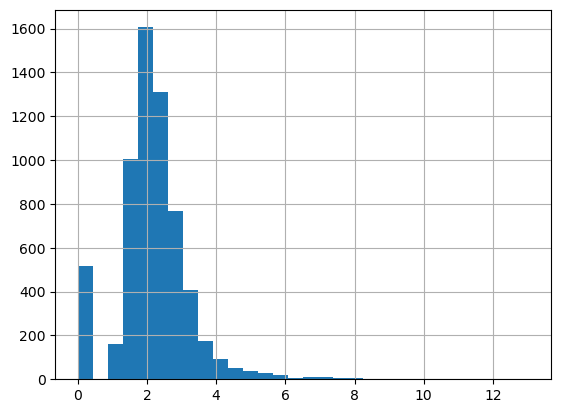

In [136]:
%matplotlib inline
nutrient_ratio['Protein'].hist(bins=30)

Below is the percentage of households that fall under the recommended intake of protein:

In [137]:
((nutrient_ratio['Protein']) < 1).mean()

0.08466119427007887

<Axes: >

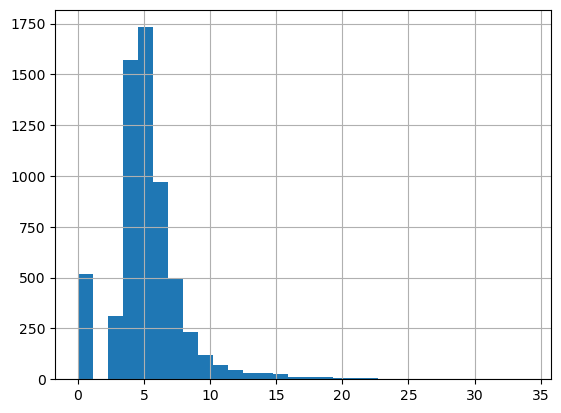

In [138]:
%matplotlib inline
nutrient_ratio['Carbohydrate'].hist(bins=30)

In [139]:
((nutrient_ratio['Carbohydrate']) < 1).mean()

0.08305166586190246

Repeat Steps 2-4 for 20%, 50%, and 80% reductions in household expenditures on products:

In [140]:
# 20% reduction in household expenditures on products:
import cfe

result_20 = cfe.Regression(y=np.log(x20.stack()),d=z)
result_20.to_pickle('./foo.pickle')

result_20 = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat_20 = result_20.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat_20 = (xhat_20.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat_20 = qhat_20.loc[:,qhat_20.count()>0]

use = fct.index.intersection(qhat_20.columns)

nutrients = qhat_20[use]@fct.loc[use,:]
# NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

z = z[rdi.columns.tolist()]

hh_rdi_20 = z@rdi.T

# Uganda RDI is per week, so make this a recommended WEEKLY intake:
hh_rwi_20 = hh_rdi_20*7

# Match up nutrient names
use_nutrients_20 = nutrients.columns.intersection(hh_rwi_20.columns)

nutrient_ratio_20 = (nutrients[use_nutrients_20].fillna(0)/hh_rwi_20[use_nutrients_20]).dropna()

<Axes: >

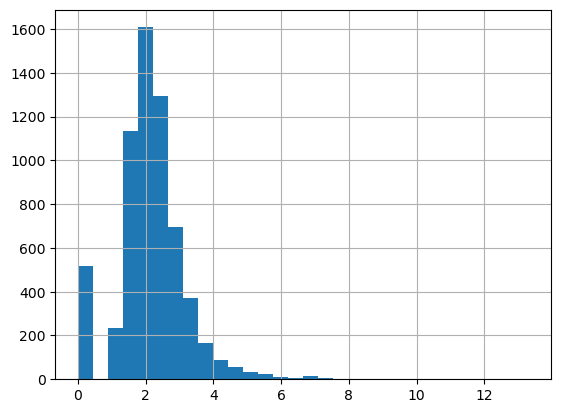

In [141]:
%matplotlib inline
nutrient_ratio_20['Protein'].hist(bins=30)

In [142]:
((nutrient_ratio_20['Protein']) < 1).mean()

0.08615728900255755

<Axes: >

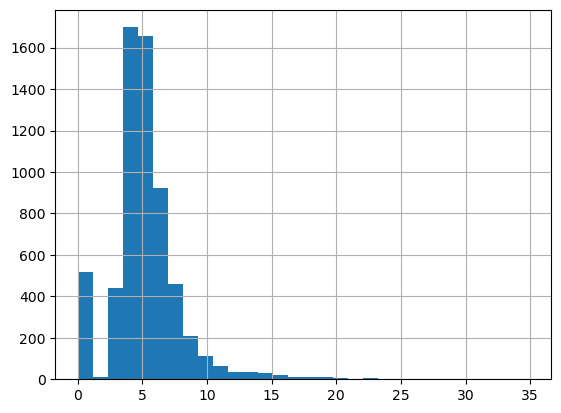

In [143]:
%matplotlib inline
nutrient_ratio_20['Carbohydrate'].hist(bins=30)

In [144]:
((nutrient_ratio_20['Carbohydrate']) < 1).mean()

0.0828005115089514

In [145]:
# 50% reduction in household expenditures on products:
import cfe

result_50 = cfe.Regression(y=np.log(x50.stack()),d=z)
result_50.to_pickle('./foo.pickle')

result_50 = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat_50 = result_50.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat_50 = (xhat_50.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat_50 = qhat_50.loc[:,qhat_50.count()>0]

use = fct.index.intersection(qhat_50.columns)

nutrients = qhat_50[use]@fct.loc[use,:]
# NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

z = z[rdi.columns.tolist()]

hh_rdi_50 = z@rdi.T

# Uganda RDI is per week, so make this a recommended WEEKLY intake:
hh_rwi_50 = hh_rdi_50*7

# Match up nutrient names
use_nutrients_50 = nutrients.columns.intersection(hh_rwi_50.columns)

nutrient_ratio_50 = (nutrients[use_nutrients_50].fillna(0)/hh_rwi_50[use_nutrients_50]).dropna()

<Axes: >

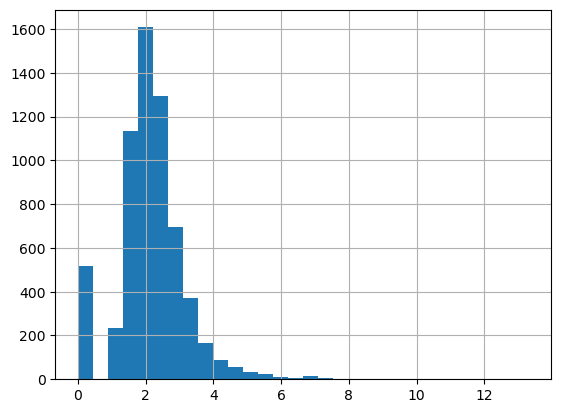

In [146]:
%matplotlib inline
nutrient_ratio_50['Protein'].hist(bins=30)

In [147]:
((nutrient_ratio_50['Protein']) < 1).mean()

0.08615728900255755

<Axes: >

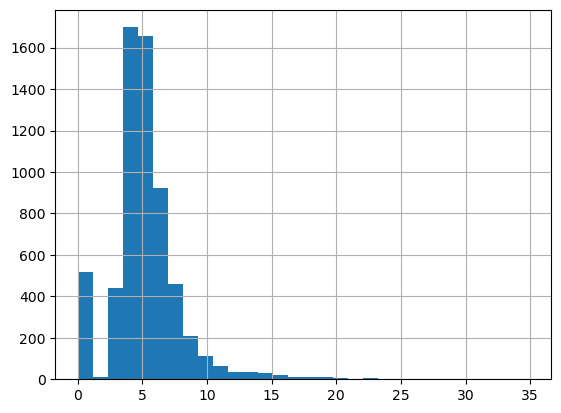

In [148]:
%matplotlib inline
nutrient_ratio_50['Carbohydrate'].hist(bins=30)

In [149]:
((nutrient_ratio_50['Carbohydrate']) < 1).mean()

0.0828005115089514

In [150]:
# 80% reduction in household expenditures on products:
import cfe

result_80 = cfe.Regression(y=np.log(x80.stack()),d=z)
result_80.to_pickle('./foo.pickle')

result_80 = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat_80 = result_80.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat_80 = (xhat_80.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat_80 = qhat_80.loc[:,qhat_80.count()>0]

use = fct.index.intersection(qhat_80.columns)

nutrients = qhat_80[use]@fct.loc[use,:]
# NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

z = z[rdi.columns.tolist()]

hh_rdi_80 = z@rdi.T

# Uganda RDI is per week, so make this a recommended WEEKLY intake:
hh_rwi_80 = hh_rdi_80*7

# Match up nutrient names
use_nutrients_80 = nutrients.columns.intersection(hh_rwi_80.columns)

nutrient_ratio_80 = (nutrients[use_nutrients_80].fillna(0)/hh_rwi_80[use_nutrients_80]).dropna()

<Axes: >

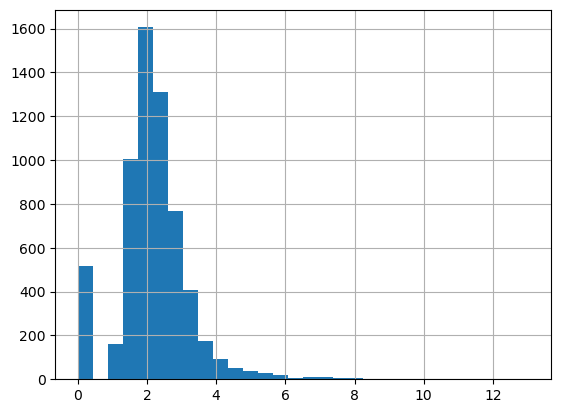

In [151]:
%matplotlib inline
nutrient_ratio_80['Protein'].hist(bins=30)

In [152]:
((nutrient_ratio_80['Protein']) < 1).mean()

0.08466119427007887

<Axes: >

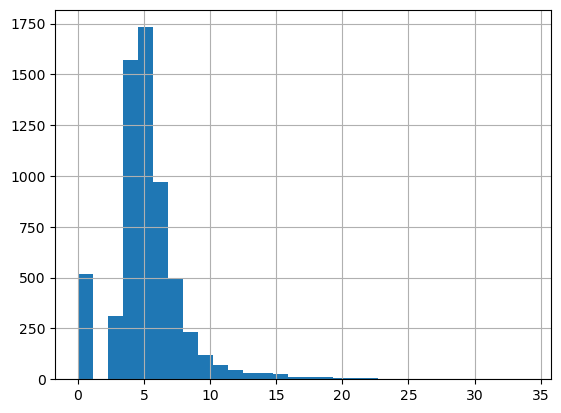

In [153]:
%matplotlib inline
nutrient_ratio_80['Carbohydrate'].hist(bins=30)

In [127]:
((nutrient_ratio_80['Carbohydrate']) < 1).mean()

0.08305166586190246